In [ ]:
# unintended bias analysis

# 1) ROC-AUC
# 2) FPED, FNED
# Sub AUC
# BPSN, BNSP
# Weighted bias score
# Pos AEG, Neg AEGb

In [111]:
# imports from other files
from danlp.models.embeddings  import load_wv_with_gensim
from gensim.models import KeyedVectors
from IPython.display import Image
import json
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf # tf backend
from typing import Dict
import utils

In [2]:
# specific imports
from sklearn.metrics import roc_auc_score, roc_curve

### Load data and models

In [3]:
# load preprocessed and oversampled data splits

if "dataset_splits.pkl" not in os.listdir('data'):
    raise Exception("Dataset splits not found. Please run main file to generate them.")

with open("data/dataset_splits.pkl", "rb") as f:
    data = pickle.load(f)
    
X_train = data["X training preprocessed and oversampled"]
y_train = data["y training preprocessed and oversampled"]
X_test = data["X test preprocessed"]
y_test = data["y test"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Shapes:
(3424,) (3424,)
(658,) (658,)


In [4]:
# load test set
with open("data/X_test_cnn.pkl", "rb") as f:
    X_test_padded = pickle.load(f)

In [5]:
# open cnn results (incl. proba and pred)
with open("models/cnn_results.pkl", "rb") as f:
    cnn_results = pickle.load(f)

#### Load and predict synthetic data

In [6]:
# load synthetic data
synth_data = pd.read_excel("g:/My Drive/ITC, 5th semester (Thesis)/Code/Github_code/create_synthetic_dataset/synthetic_data.xlsx")

# all data
X_synth = synth_data['text']
y_synth = synth_data['toxic']

print(len(X_synth), "sentences")
synth_data.head()

# load preprocessed, tokenized and padded version of X_synth
with open("data/X_synthetic_data_prepared.pkl", "rb") as f:
    X_synth_padded = pickle.load(f)

12780 sentences


In [7]:
# predict synthetic dataset using models
# store predictions in the dataframe

for i in range(1,11): # for each version of the model
    model_path = "models/initializations/cnn"+str(i)+".keras"
    model = tf.keras.models.load_model(model_path) # load model
    print(model_path)
    
    # predict synthetic dataset
    synth_data["proba"+str(i)] = model.predict(X_synth_padded)
    synth_data["pred"+str(i)] = synth_data["proba"+str(i)] > 0.5
    synth_data["pred"+str(i)] = synth_data["pred"+str(i)].astype(int)

models/initializations/cnn1.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn2.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn3.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn4.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn5.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn6.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn7.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn8.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn9.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn10.keras
400/400 [==============================] - 2s 5ms/step


In [8]:
synth_data.head()

,text,group,identity_term,toxic,proba1,pred1,proba2,pred2,proba3,pred3,...,proba6,pred6,proba7,pred7,proba8,pred8,proba9,pred9,proba10,pred10
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,0.860267,1,0.790226,1,0.780334,1,...,0.938523,1,0.592184,1,0.495544,0,0.972040,1,0.534409,1
1,piger er klamme og generelt bare nederen,F,piger,1,0.935613,1,0.877067,1,0.945209,1,...,0.972336,1,0.820294,1,0.785956,1,0.994204,1,0.648751,1
2,damer er klamme og generelt bare nederen,F,damer,1,0.871904,1,0.810125,1,0.841771,1,...,0.956350,1,0.719296,1,0.469115,0,0.990063,1,0.563611,1
3,koner er klamme og generelt bare nederen,F,koner,1,0.937717,1,0.819467,1,0.881572,1,...,0.949109,1,0.748725,1,0.713821,1,0.992084,1,0.567955,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,0.953397,1,0.928839,1,0.973849,1,...,0.985285,1,0.861373,1,0.736401,1,0.997373,1,0.662934,1


### 1) ROC-AUC

In [9]:
# ROC-AUC on test set 

aucs_test = [roc_auc_score(y_test, cnn_results[model]['proba']) for model in cnn_results.keys()]
print("Avg. AUC:", round(np.mean(aucs_test), 4))

Avg. AUC: 0.7981


In [10]:
# ROC-AUC on synthetic data set 

aucs_synthetic = []
for i in range(1,11):
    proba = synth_data['proba'+str(i)]
    aucs_synthetic.append(roc_auc_score(y_synth, proba))

print("Avg. AUC:", round(np.mean(aucs_synthetic), 4))

Avg. AUC: 0.7223


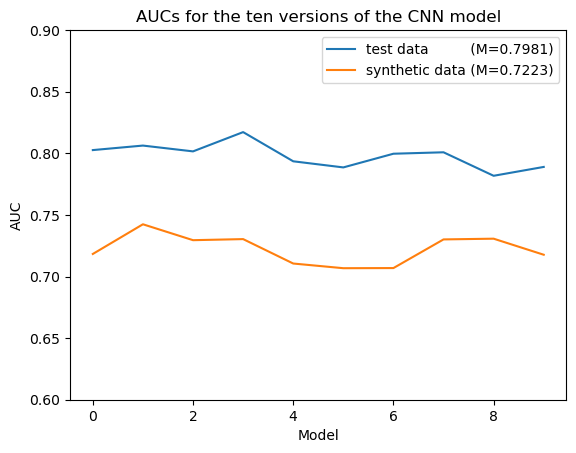

In [11]:
# plot aucs for both datasets
plt.plot(aucs_test, label=f"test data   (M={round(np.mean(aucs_test), 4)})")
plt.plot(aucs_synthetic, label=f"synthetic data (M={round(np.mean(aucs_synthetic), 4)})")
plt.ylim(.6, .9)
plt.title("AUCs for the ten versions of the CNN model")
plt.legend(loc="upper right")
plt.ylabel("AUC")
plt.xlabel("Model")
plt.show()

### 2) FPED, FNED

In [12]:
def compute_confusion_counts(y_actual:np.ndarray, y_pred:np.ndarray) -> Dict[str, int]:
    """Computes confusion counts, i.e. true positive, true negative, false positive, and false negative.

    Args:
        y_actual (np.ndarray): actual labels
        y_pred (np.ndarray): predicted labels

    Returns:
        Dict[str, int]: keys = metric name, values = counts
    """
    tp = sum([a==1 and p==1 for (a, p) in zip(y_actual, y_pred)])
    tn = sum([a==0 and p==0 for (a, p) in zip(y_actual, y_pred)])
    fp = sum([a==0 and p==1 for (a, p) in zip(y_actual, y_pred)])
    fn = sum([a==1 and p==0 for (a, p) in zip(y_actual, y_pred)])
    return {"tp":tp, "tn":tn, "fp":fp, "fn":fn}

In [13]:
# test this function using the latest model
print(compute_confusion_counts(y_synth, synth_data['pred10']))
print(confusion_matrix(y_synth, synth_data['pred10']))

{'tp': 512, 'tn': 6305, 'fp': 85, 'fn': 5878}
[[6305   85]
 [5878  512]]


In [14]:
# TODO check these calculatiosn and synonyms

def compute_confusion_rates(y_actual:np.ndarray, y_pred:np.ndarray) -> Dict[str, int]:
    """Compute the confusion rates, i.e. true positive rate, true negative rate, false positive rate, and false negative rate.

    Args:
        y_actual (np.ndarray): actual labels
        y_pred (np.ndarray): predicted labels

    Returns:
        Dict[str, int]: keys = metric name, values = rates
    """
    conf_counts = compute_confusion_counts(y_actual, y_pred)
    actually_pos = conf_counts['tp'] + conf_counts['fn']
    actually_neg = conf_counts['tn'] + conf_counts['fp']
    
    # true positive rate = sensitivity = recall
    tpr = conf_counts['tp'] / actually_pos

    # true negative rate = specificity
    tnr = conf_counts['tn'] / actually_neg
    
    # false positive rate = fall-out
    fpr = 1 - tnr
    
    # false negative rate = miss rate
    fnr = 1 - tpr
    
    return {
        "tpr": tpr,
        "tnr": tnr,
        "fpr": fpr,
        "fnr": fnr
    }

In [15]:
# test this function using the latest model
compute_confusion_rates(y_synth, synth_data['pred10'])

{'tpr': 0.08012519561815336,
 'tnr': 0.986697965571205,
 'fpr': 0.013302034428794962,
 'fnr': 0.9198748043818467}

In [40]:
# # calculate per-term fpr for the latest model

# term_group = synth_data.groupby('identity_term')
# fprs = dict()

# for (t_name, t_df) in term_group: # t = term 
#     t_fprs = []
#     for i in range(1,11):
#         rates = compute_confusion_rates(t_df['toxic'], t_df['pred'+str(i)])
#         t_fprs.append(rates['fpr'])
#     fprs[t_name] = t_fprs

In [39]:
# fprs

In [41]:
# calculate per-term fprs and fnrs 

term_group = synth_data.groupby('identity_term')
per_term_fprs = dict()
background_fprs = dict()
per_term_fnrs = dict()
background_fnrs = dict()

for i in range(1,11): # for each model variant

    t_fprs = dict()
    t_fnrs = dict()
    for (t_name, t_df) in term_group: # for each term (t=term)
        rates = compute_confusion_rates(t_df['toxic'], t_df['pred'+str(i)])
        t_fprs[t_name] = rates['fpr']
        t_fnrs[t_name] = rates['fnr']

    per_term_fprs[str(i)] = t_fprs
    per_term_fnrs[str(i)] = t_fnrs
    
    background_rates = compute_confusion_rates(synth_data['toxic'], synth_data['pred'+str(i)])
    background_fprs[str(i)] = background_rates['fpr']
    background_fnrs[str(i)] = background_rates['fnr']

In [42]:
per_term_fprs

{'1': {'androgyn': 0.0,
  'androgyne': 0.0,
  'bedstefar': 0.0,
  'bedstefædre': 0.0,
  'bedstemor': 0.0,
  'bedstemødre': 0.0,
  'bror': 0.0,
  'brødre': 0.0,
  'dame': 0.0,
  'damer': 0.0,
  'datter': 0.0,
  'dreng': 0.0,
  'drenge': 0.4444444444444444,
  'døtre': 0.0,
  'en androgyn': 0.0,
  'en bedstefar': 0.0,
  'en bedstemor': 0.0,
  'en bror': 0.0,
  'en dame': 0.0,
  'en datter': 0.0,
  'en dreng ': 0.0,
  'en far': 0.0,
  'en fyr': 0.0,
  'en fætter': 0.0,
  'en genderqueer person': 0.0,
  'en han': 0.0,
  'en hermafrodit': 0.0,
  'en herre': 0.0,
  'en hun': 0.0,
  'en husbond': 0.0,
  'en hustru': 0.0,
  'en ikkebinær person': 0.0,
  'en interkønnet person': 0.0,
  'en intetkønnet person': 0.0,
  'en kone': 0.0,
  'en kusine': 0.0,
  'en kvinde': 0.0,
  'en lgbt person': 0.0,
  'en mand': 0.0,
  'en mor': 0.0,
  'en nonbinær person': 0.0,
  'en pige': 0.0,
  'en queer person': 0.0,
  'en svigerdatter': 0.0,
  'en svigerinde': 0.0,
  'en svigersøn': 0.0,
  'en svoger': 0.0,
 

In [43]:
background_fprs

{'1': 0.018466353677621283,
 '2': 0.005633802816901401,
 '3': 0.018153364632237823,
 '4': 0.015336463223787122,
 '5': 0.022691705790297334,
 '6': 0.025195618153364685,
 '7': 0.025195618153364685,
 '8': 0.007824726134585291,
 '9': 0.025821596244131495,
 '10': 0.013302034428794962}

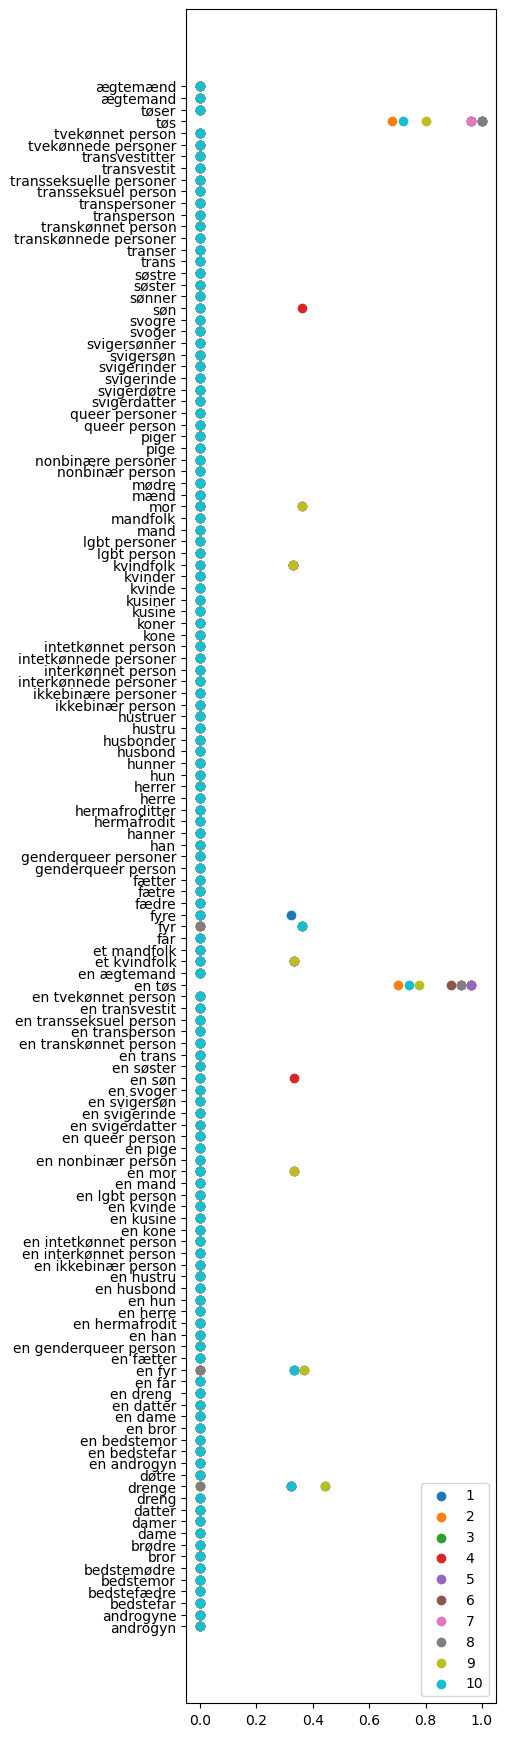

In [44]:
# plot fprs per term

plt.figure(figsize=(4,22))
for i in range(1, 11):
    y = per_term_fprs[str(i)].keys()
    x = per_term_fprs[str(i)].values()
    plt.scatter(x, y, label=i)
plt.legend()
plt.show()

In [45]:
def compute_fped(background_fpr:float, per_term_fprs:Dict[str, float]):
    fped = sum(
        abs(background_fpr - fpr_t)
        for fpr_t in per_term_fprs.values()
    )
    return fped

In [46]:
fpeds = [compute_fped(background_fprs[str(i)], per_term_fprs[str(i)]) for i in range(1,11)]

print("Mean FPED:", np.mean(fpeds))

Mean FPED: 5.223457349572481


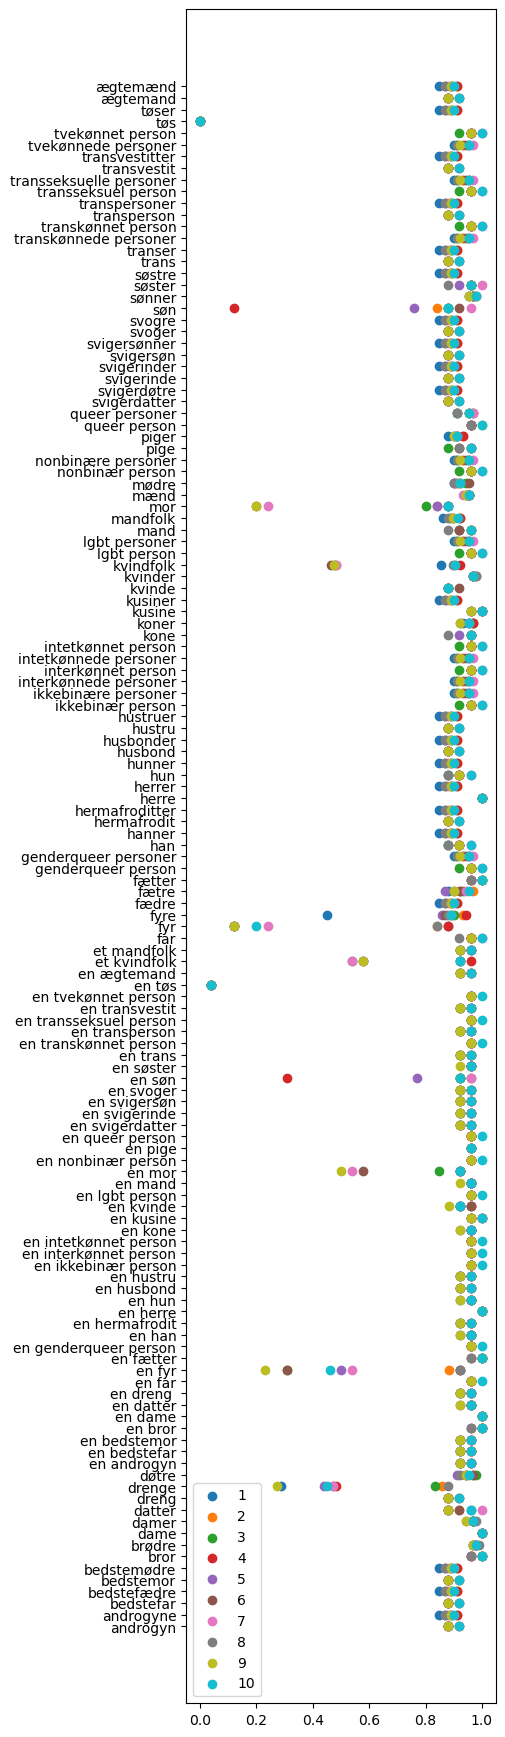

In [47]:
# plot fnrs per term

plt.figure(figsize=(4,22))
for i in range(1, 11):
    y = per_term_fnrs[str(i)].keys()
    x = per_term_fnrs[str(i)].values()
    plt.scatter(x, y, label=i)
plt.legend()
plt.show()

In [48]:
def compute_fned(background_fnr:float, per_term_fnrs:Dict[str, float]):
    fned = sum(
        abs(background_fnr - fnr_t)
        for fnr_t in per_term_fnrs.values()
    )
    return fned

In [49]:
fneds = [compute_fned(background_fnrs[str(i)], per_term_fnrs[str(i)]) for i in range(1,11)]

print("Mean FNED:", np.mean(fneds))

Mean FNED: 9.076306461818358


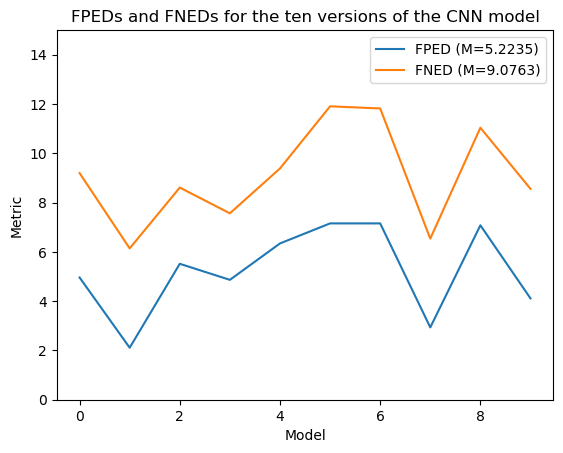

In [50]:
# plot fped and fneds
plt.plot(fpeds, label=f"FPED (M={round(np.mean(fpeds),4)})")
plt.plot(fneds, label=f"FNED (M={round(np.mean(fneds),4)})")
plt.ylim(0, 15)
plt.title("FPEDs and FNEDs for the ten versions of the CNN model")
plt.legend(loc="upper right")
plt.ylabel("Metric")
plt.xlabel("Model")
plt.show()

### 3) Subgroup AUC

In [ ]:
# pseudocode

# initialize dict {1: {subAUC: VALUE}, ..., 10: {subAUC: VALUE}}

# for each model initialization (n=10)
    # initialize inner/nested dict {subAUC: VALUE}
    # for each term in synthetic data:
        # calculate auc using roc_auc_score(y_actual, y_proba) # remember that auc is calculate on probas, not preds!!!
        # store result in inner/nested dict

In [53]:
synth_data.head(2)

,text,group,identity_term,toxic,proba1,pred1,proba2,pred2,proba3,pred3,...,proba6,pred6,proba7,pred7,proba8,pred8,proba9,pred9,proba10,pred10
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,0.860267,1,0.790226,1,0.780334,1,...,0.938523,1,0.592184,1,0.495544,0,0.972040,1,0.534409,1
1,piger er klamme og generelt bare nederen,F,piger,1,0.935613,1,0.877067,1,0.945209,1,...,0.972336,1,0.820294,1,0.785956,1,0.994204,1,0.648751,1


In [66]:
term_group = synth_data.groupby('identity_term')
per_term_scores = dict()

for i in range(1,11): # for each model variant
    
    t_scores = dict() # store scores for the current term 

    for (t_name, t_df) in term_group: # for each term (t=term)
        subAUC = roc_auc_score(t_df['toxic'], t_df['proba'+str(i)])
        t_scores[t_name] = subAUC
    
    per_term_scores[str(i)] = t_scores

In [67]:
per_term_scores

{'1': {'androgyn': 0.8024,
  'androgyne': 0.7014652014652014,
  'bedstefar': 0.7896000000000001,
  'bedstefædre': 0.7197802197802198,
  'bedstemor': 0.7896000000000001,
  'bedstemødre': 0.7164224664224664,
  'bror': 0.7832,
  'brødre': 0.7349206349206349,
  'dame': 0.784,
  'damer': 0.7407814407814408,
  'datter': 0.8128,
  'dreng': 0.8096,
  'drenge': 0.7134310134310134,
  'døtre': 0.7280219780219781,
  'en androgyn': 0.7200854700854701,
  'en bedstefar': 0.7072649572649573,
  'en bedstemor': 0.7072649572649573,
  'en bror': 0.7286324786324787,
  'en dame': 0.6823361823361823,
  'en datter': 0.8176638176638178,
  'en dreng ': 0.7008547008547009,
  'en far': 0.7400284900284901,
  'en fyr': 0.7307692307692308,
  'en fætter': 0.7371794871794872,
  'en genderqueer person': 0.8376068376068376,
  'en han': 0.7015669515669516,
  'en hermafrodit': 0.6944444444444444,
  'en herre': 0.6759259259259259,
  'en hun': 0.7015669515669516,
  'en husbond': 0.6944444444444444,
  'en hustru': 0.70085470

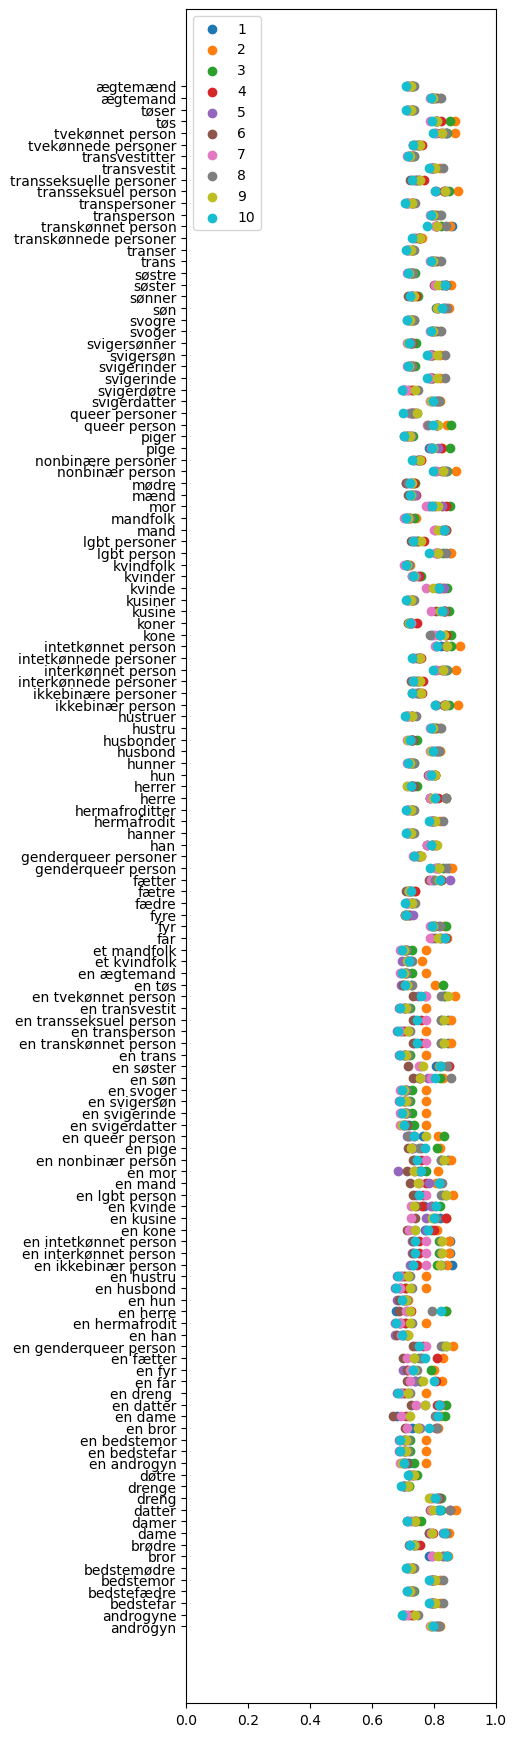

In [69]:
# plot scores per term

plt.figure(figsize=(4,22))
for i in range(1, 11):
    y = per_term_scores[str(i)].keys()
    x = per_term_scores[str(i)].values()
    plt.scatter(x, y, label=i)
plt.xlim(0,1)
plt.legend()
plt.show()

In [106]:
# calculate average subAUC (across model initializations)

# convert to df
per_term_scores_df = pd.DataFrame(per_term_scores)
display(per_term_scores_df.head())

# add column with row mean
per_term_scores_df['subAUC_mean'] = per_term_scores_df.mean(axis=1)

,1,2,3,4,5,6,7,8,9,10
androgyn,0.802400,0.819200,0.816800,0.795200,0.810400,0.808800,0.785600,0.816800,0.791200,0.796000
androgyne,0.701465,0.732234,0.717949,0.729915,0.699023,0.707082,0.712332,0.747741,0.739316,0.695971
bedstefar,0.789600,0.819200,0.804000,0.795200,0.797600,0.796000,0.785600,0.829600,0.804000,0.783200
bedstefædre,0.719780,0.731013,0.736264,0.729915,0.717338,0.725397,0.712332,0.731868,0.722222,0.714286
bedstemor,0.789600,0.819200,0.804000,0.795200,0.797600,0.796000,0.785600,0.829600,0.804000,0.783200


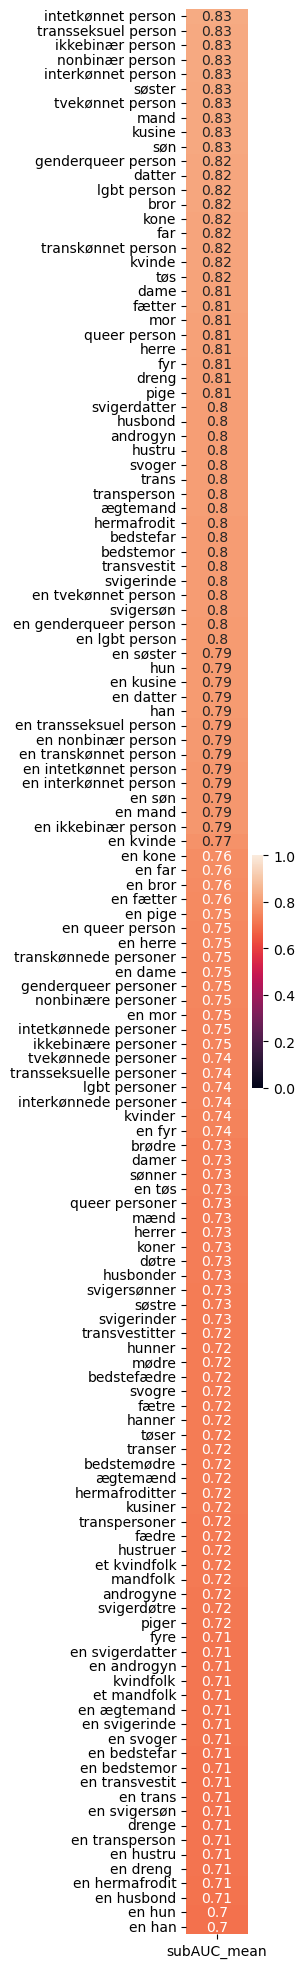

In [126]:
# df of just the averages
per_term_avgscores_df = pd.DataFrame(per_term_scores_df['subAUC_mean'])
per_term_avgscores_df.sort_values(by='subAUC_mean', ascending=False, inplace=True)

# plot average termwise auc scores
plt.figure(figsize=(1,25))
sns.heatmap(per_term_avgscores_df, annot=True, vmin=0.0, vmax=1.0)
plt.show()

#TODO should this be sorted? 
#TODO add BPSN etc. here later like in other articles
#TODO maybe color words by category and plurality, e.g. female=red, male=blue, other=green, plural=deep, singular=light for readability. Maybe just some identites?

### 4) BPSN, BNSP

In [ ]:
# BPSN and BNSP

# for group in groups:
#     df[group] = df[group] >= 0.5
#     categories.loc[group,'SUB'] = auc(df[df[group]])
#     bpsn = ((~df[group] & df['target'])    #background positive
#             | (df[group] & ~df['target'])) #subgroup negative
#     categories.loc[group,'BPSN'] = auc(df[bpsn])
#     bnsp = ((~df[group] & ~df['target'])   #background negative
#             | (df[group] & df['target']))  #subgrooup positive
#     categories.loc[group,'BNSP'] = auc(df[bnsp])

In [169]:
per_term_scores

{'1': {'androgyn': 0.8024,
  'androgyne': 0.7014652014652014,
  'bedstefar': 0.7896000000000001,
  'bedstefædre': 0.7197802197802198,
  'bedstemor': 0.7896000000000001,
  'bedstemødre': 0.7164224664224664,
  'bror': 0.7832,
  'brødre': 0.7349206349206349,
  'dame': 0.784,
  'damer': 0.7407814407814408,
  'datter': 0.8128,
  'dreng': 0.8096,
  'drenge': 0.7134310134310134,
  'døtre': 0.7280219780219781,
  'en androgyn': 0.7200854700854701,
  'en bedstefar': 0.7072649572649573,
  'en bedstemor': 0.7072649572649573,
  'en bror': 0.7286324786324787,
  'en dame': 0.6823361823361823,
  'en datter': 0.8176638176638178,
  'en dreng ': 0.7008547008547009,
  'en far': 0.7400284900284901,
  'en fyr': 0.7307692307692308,
  'en fætter': 0.7371794871794872,
  'en genderqueer person': 0.8376068376068376,
  'en han': 0.7015669515669516,
  'en hermafrodit': 0.6944444444444444,
  'en herre': 0.6759259259259259,
  'en hun': 0.7015669515669516,
  'en husbond': 0.6944444444444444,
  'en hustru': 0.70085470

In [168]:
# got it to work for multiple terms, one model, now store for each model variant.
# merge with version with subAUC

for (t_name, t_df) in term_group:
    
    # subset data for bpsn and bnsp
    bgr_df = synth_data[synth_data['identity_term']!=t_name] # background data = data that doens't mention the current identity term
    
    # BPSN data = background positive AND subgroup negative
    bgr_pos = bgr_df[bgr_df['toxic']==1] # background positive = D+ = positive examples in rest of data
    sub_neg = t_df[t_df['toxic']==0] # subgroup negative = Dg- = negative examples in subgroup
    bpsn_df = pd.concat([bgr_pos, sub_neg])
    
    # BNSP data = background negative AND subgroup positive
    bgr_neg = bgr_df[bgr_df['toxic']==0] # background negative = D- = negative examples in rest of data
    sub_pos = t_df[t_df['toxic']==1] # subgroup positive = Dg+ = positive examples in subgroup
    bnsp_df = pd.concat([bgr_neg, sub_pos])
    
    # calculate BPSN and BNSP scores
    bpsn_score = roc_auc_score(bpsn_df['toxic'], bpsn_df['proba1'])
    bnsp_score = roc_auc_score(bnsp_df['toxic'], bnsp_df['proba1'])

    print(t_name, bpsn_score, bnsp_score)

androgyn 0.6991516103692066 0.8402482325216024
androgyne 0.6079113086733344 0.8091365777080063
bedstefar 0.6946488609583661 0.8402985074626866
bedstefædre 0.6144246882221165 0.8098935984650271
bedstemor 0.6946488609583661 0.8402985074626866
bedstemødre 0.6128071475190066 0.8101909994767138
bror 0.9808735271013355 0.35478083267871174
brødre 0.9778553915083523 0.34705389848246987
dame 0.9920911233307148 0.1722985074626866
damer 0.9009578239932265 0.5365271236699808
datter 0.90455930871956 0.6032804399057344
dreng 0.6991233307148469 0.8438900235663785
drenge 0.3642518212767459 0.9569788941217513
døtre 0.8218835441251697 0.640870399441828
en androgyn 0.697694787811067 0.7388084962342388
en bedstefar 0.6977471657704217 0.7318028506147318
en bedstemor 0.6977471657704217 0.7318028506147318
en bror 0.9817055427520543 0.28510076282353514
en dame 0.9927602020625276 0.11723727317786725
en datter 0.9091591591591592 0.5666835914360667
en dreng  0.6935569290220454 0.7318300511369819
en far 0.9378040

### Alltogether

In [174]:
# this work, but i'd rather organize it differently

term_group = synth_data.groupby('identity_term')
per_term_scores = dict()

for i in range(1,11): # for each model variant
    
    t_scores = dict() # store scores for the current term 

    for (t_name, t_df) in term_group: # for each term (t=term)
        
        # subAUC = AUC(sub_pos and sub_neg)
        subAUC = roc_auc_score(t_df['toxic'], t_df['proba'+str(i)])
        
        # subset data for bpsn and bnsp
        bgr_df = synth_data[synth_data['identity_term']!=t_name] # background data = data that doens't mention the current identity term
        
        # BPSN = AUC(background positive AND subgroup negative)
        bgr_pos = bgr_df[bgr_df['toxic']==1] # background positive = D+ = positive examples in rest of data
        sub_neg = t_df[t_df['toxic']==0] # subgroup negative = Dg- = negative examples in subgroup
        bpsn_df = pd.concat([bgr_pos, sub_neg])
        bpsn_score = roc_auc_score(bpsn_df['toxic'], bpsn_df['proba'+str(i)])
        
        # BNSP = AUC(background negative AND subgroup positive)
        bgr_neg = bgr_df[bgr_df['toxic']==0] # background negative = D- = negative examples in rest of data
        sub_pos = t_df[t_df['toxic']==1] # subgroup positive = Dg+ = positive examples in subgroup
        bnsp_df = pd.concat([bgr_neg, sub_pos])
        bnsp_score = roc_auc_score(bnsp_df['toxic'], bnsp_df['proba'+str(i)])
    
        t_scores[t_name] = {'subAUC':subAUC, 'BPSN':bpsn_score, 'BNSP':bnsp_score}
        
    per_term_scores[str(i)] = t_scores

In [179]:
# for each term, calculate for each model and then the average

per_term_scores = dict()

for (t_name, t_df) in term_group: # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data['identity_term']!=t_name] # background data = data that doens't mention the current identity term
    bpsn_df = pd.concat([bgr_df[bgr_df['toxic']==1], # background positive
                         t_df[t_df['toxic']==0]]) # subgroup negative
    bnsp_df = pd.concat([bgr_df[bgr_df['toxic']==0], # background negative
                         t_df[t_df['toxic']==1]]) # subgroup positive
    
    subAUCs, BPSNs, BNSPs = [], [], []
    for model_i in range(1, 11): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df['toxic'], t_df['proba'+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df['toxic'], bpsn_df['proba'+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df['toxic'], bnsp_df['proba'+str(model_i)]))
    
    scores = {
        'subAUC_avg': np.mean(subAUCs),
        'BPSN_avg': np.mean(BPSNs),
        'BNSP_avg': np.mean(BNSPs),
        'subAUC_all': subAUCs,
        'BPSN_all': BPSNs,
        'BNSP_all': BPSNs
    }
    
    per_term_scores[t_name] = scores

In [228]:
per_term_scores_df = pd.DataFrame(per_term_scores).T

subAUC_avg    float64
BPSN_avg      float64
BNSP_avg      float64
dtype: object


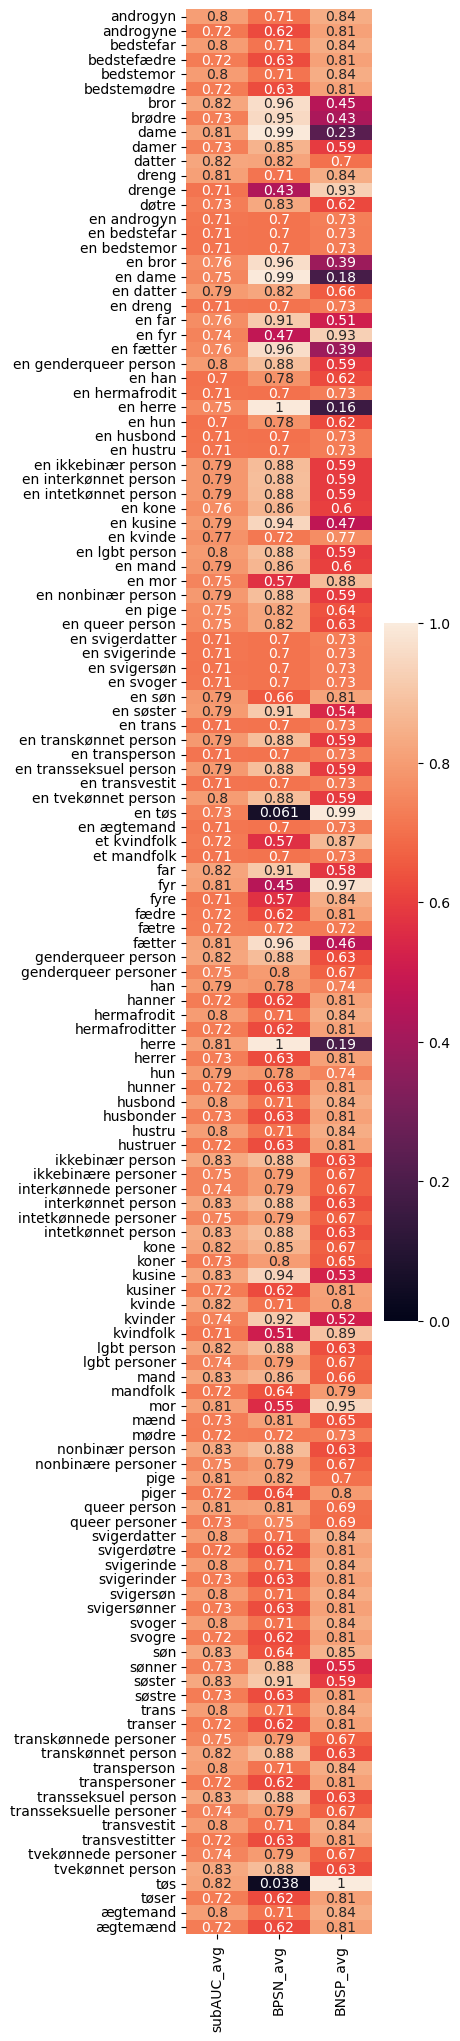

In [234]:
# df of just the averages
per_term_avgscores_df = pd.DataFrame(per_term_scores_df.loc[:, 'subAUC_avg':'BNSP_avg'], dtype='float')
print(per_term_avgscores_df.dtypes)

# plot average termwise auc scores
plt.figure(figsize=(3,25))
sns.heatmap(per_term_avgscores_df, annot=True, vmin=0.0, vmax=1.0)
plt.show()

#TODO maybe color words by category and plurality, e.g. female=red, male=blue, other=green, plural=deep, singular=light for readability. Maybe just some identites?

### Overall metric (weighted score)

In [272]:
from typing import List

In [274]:
# code modified from: https://www.kaggle.com/code/dborkan/benchmark-kernel/notebook#Create-a-text-tokenizer

def power_mean(series, p):
    # source: https://www.kaggle.com/code/dborkan/benchmark-kernel/notebook#Create-a-text-tokenizer
    # unedited from source
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_weighted_bias_score(bias_df:pd.DataFrame, overall_auc:float, POWER:float=-5, OVERALL_MODEL_WEIGHT:float=0.25, SUBMETRIC_WEIGHTS:List[float]=[0.25,0.25,0.25], SUBMETRIC_NAMES:List[str]=['subAUC_avg', 'BPSN_avg', 'BNSP_avg']) -> float:
    """Calculate the weighted bias score by combining the overall AUC and the generalized mean of the bias submetrics. See description at https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation 

    Args:
        bias_df (pd.DataFrame): DataFrame containing the per-term bias submetric scores, e.g. subAUC, BPSN, and BNSP.
        overall_auc (float): ROC-AUC on the entire synthetic dataset. 
        POWER (float, optional): the power value. Defaults to -5.
        OVERALL_MODEL_WEIGHT (float, optional): the weight given to the overall model AUC. Defaults to 0.25.
        SUBMETRIC_WEIGHTS (List, optional): the weights given to each of the submetrics. Defaults to [0.25,0.25,0.25].
        SUBMETRIC_NAMES (List, optional): a list of the submetric names as they are used in the bias_df. Defaults to ['subAUC_avg', 'BPSN_avg', 'BNSP_avg'].

    Returns:
        float: the weighted bias score.
    """
    # source: https://www.kaggle.com/code/dborkan/benchmark-kernel/notebook#Create-a-text-tokenizer
    # slightly edited
    bias_score = OVERALL_MODEL_WEIGHT * overall_auc + np.sum([
        SUBMETRIC_WEIGHTS[0]*power_mean(bias_df[SUBMETRIC_NAMES[0]], POWER), # e.g. subAUC
        SUBMETRIC_WEIGHTS[1]*power_mean(bias_df[SUBMETRIC_NAMES[1]], POWER), # e.g. BPSN
        SUBMETRIC_WEIGHTS[2]*power_mean(bias_df[SUBMETRIC_NAMES[2]], POWER)  # e.g. BNSP
    ])
    return bias_score

In [277]:
print("Weighted bias score:", round(get_weighted_bias_score(per_term_avgscores_df, np.mean(aucs_synthetic)),4))

Weighted bias score: 0.4851
